In [1]:
!pip install google-play-scraper
!pip install wordcloud
!pip install Sastrawi
!pip install nltk
!pip install tensorflow
!pip install keras

In [2]:
import csv
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import requests
from io import StringIO

from google_play_scraper import app, reviews, Sort, reviews_all

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Scraping Data Shopee Pay


In [3]:
scrapreview = reviews_all(
    'com.shopeepay.id',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=10500
)

In [4]:
with open('ulasan_shopee_pay.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [5]:
spay_df = pd.DataFrame(scrapreview)
spay_df.shape
spay_df.head()
spay_df.to_csv('ulasan_shopee_pay.csv', index=False)

# Membuat DataFrame dari hasil scrapreview
spay_df = pd.DataFrame(scrapreview)

In [6]:
jumlah_ulasan, jumlah_kolom = spay_df.shape
print(f"Jumlah ulasan: {jumlah_ulasan}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah ulasan: 58389
Jumlah kolom: 11


In [7]:
spay_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a4f3fd22-f9b6-4762-8fdb-fc4aac61be79,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Andalan terbagus top banget, tdk beriklan, tdk...",5,764,1.28.03,2025-04-17 17:31:37,Hi Kak. Terima kasih atas review positifnya. J...,2025-04-18 06:41:10,1.28.03
1,dd6fca8b-04d7-4520-a222-43df1f5a9110,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aku suka2"" lancar sekali, gak beriklan, tdk le...",5,763,1.27.06,2025-04-13 15:33:58,"Hai kakDarona, makasih ya untuk bintang dan f...",2025-04-13 06:44:25,1.27.06
2,fa691daa-38b8-48f0-a18b-e7cc1574222b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi terbagus oke sekali, gak beriklan, td...",5,753,1.27.06,2025-04-13 12:51:54,"Hai kak, makasih untuk feedbacknya. shopee ...",2025-04-13 05:50:10,1.27.06


# Text Prepocecing

In [8]:
def cleaningText(text):
    text = text.replace(',', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.replace('  ', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

## Slang Words

In [9]:
SlangWords = {
    '@': 'di', 'abis': 'habis', 'bgt': 'banget', 'bkn': 'bukan', 'btw': 'ngomong-ngomong', 'cm': 'cuma', 'd': 'di', 'dah': 'sudah', 'deh': 'lah', 'dgn': 'dengan',
    'dll': 'dan lain-lain', 'dsb': 'dan sebagainya', 'g': 'enggak', 'ga': 'tidak', 'gatau': 'tidak tahu', 'gpp': 'tidak apa-apa', 'gue': 'saya', 'gw': 'saya', 'jg': 'juga', 'jgn': 'jangan',
    'kl': 'kalau', 'klo': 'kalau', 'km': 'kamu', 'knp': 'kenapa', 'kok': 'kenapa', 'krn': 'karena', 'lgsg': 'langsung', 'lo': 'kamu', 'lu': 'kamu', 'males': 'malas',
    'msh': 'masih', 'n': 'dan', 'ngaco': 'tidak karuan', 'ngapain': 'sedang apa', 'nih': 'ini', 'nyesel': 'menyesal', 'org': 'orang', 'pdhl': 'padahal', 'pls': 'tolong',
    'ribet': 'rumit', 'sm': 'sama', 'so': 'jadi', 'tp': 'tapi', 'tpi': 'tapi', 'udh': 'sudah', 'utk': 'untuk', 'wkt': 'waktu', 'ya': 'iya', 'bagu': 'bagus',
    'yg': 'yang', 'ywdh': 'ya sudah', 'zaman now': 'zaman sekarang', 'lebay': 'berlebihan', 'mager': 'malas gerak', 'gercep': 'gerak cepat', 'santuy': 'santai', 'kuy': 'ayo', 'kek': 'seperti', 'lelet': 'lambat', 'mendingan': 'lebih baik', 'rese': 'menyebalkan',
    'tq': 'terima kasih', 'pls': 'please', 'bro': 'saudara', 'rp': 'rupiah', 'bs': 'bisa', 'mayan': 'lumayan', 'apk': 'aplikasi', 'bagusss': 'bagus', 'bagussss': 'bagus', 'mantappp': 'mantap',
    'ajib': 'ajaib', 'mantabs': 'mantap', 'ngok': 'babi', 'cepet': 'cepat', 'cpt': 'cepat', 'kncg': 'kencang', 'boss': 'bos', 'smoga': 'semoga', 'zangat': 'sangat', 'oc': 'oke', 'mantul': 'mantap', 'trus': 'terus',
    'mantab': 'mantap', 'ooke': 'oke', 'dg': 'dengan'}

In [10]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in SlangWords:
            fixed_words.append(SlangWords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [11]:
clean_df = spay_df.dropna()
clean_df = clean_df.drop_duplicates()
print("Baris : ",clean_df.shape[0])

Baris :  40500


In [12]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [13]:
clean_df = clean_df[clean_df['text_akhir'] != '']
clean_df = clean_df.reset_index(drop=True)
print("Baris : ", clean_df.shape[0])

Baris :  38904


In [14]:
clean_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,a4f3fd22-f9b6-4762-8fdb-fc4aac61be79,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Andalan terbagus top banget, tdk beriklan, tdk...",5,764,1.28.03,2025-04-17 17:31:37,Hi Kak. Terima kasih atas review positifnya. J...,2025-04-18 06:41:10,1.28.03,Andalan terbagus top banget tdk beriklan tdk a...,andalan terbagus top banget tdk beriklan tdk a...,andalan terbagus top banget tdk beriklan tdk a...,"[andalan, terbagus, top, banget, tdk, beriklan...","[andalan, terbagus, top, banget, tdk, beriklan...",andalan terbagus top banget tdk beriklan tdk b...
1,dd6fca8b-04d7-4520-a222-43df1f5a9110,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aku suka2"" lancar sekali, gak beriklan, tdk le...",5,763,1.27.06,2025-04-13 15:33:58,"Hai kakDarona, makasih ya untuk bintang dan f...",2025-04-13 06:44:25,1.27.06,Aku suka lancar sekali gak beriklan tdk lelet ...,aku suka lancar sekali gak beriklan tdk lelet ...,aku suka lancar sekali gak beriklan tdk lambat...,"[aku, suka, lancar, sekali, gak, beriklan, tdk...","[suka, lancar, beriklan, tdk, lambat, bug, oke...",suka lancar beriklan tdk lambat bug okelah ber...
2,fa691daa-38b8-48f0-a18b-e7cc1574222b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi terbagus oke sekali, gak beriklan, td...",5,753,1.27.06,2025-04-13 12:51:54,"Hai kak, makasih untuk feedbacknya. shopee ...",2025-04-13 05:50:10,1.27.06,Aplikasi terbagus oke sekali gak beriklan tdk ...,aplikasi terbagus oke sekali gak beriklan tdk ...,aplikasi terbagus oke sekali gak beriklan tdk ...,"[aplikasi, terbagus, oke, sekali, gak, berikla...","[aplikasi, terbagus, oke, beriklan, tdk, bug, ...",aplikasi terbagus oke beriklan tdk bug lemot p...


In [15]:
lexicon_positive = dict()
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [16]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [17]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    20577
negative     9684
neutral      8643
Name: count, dtype: int64


# Visual

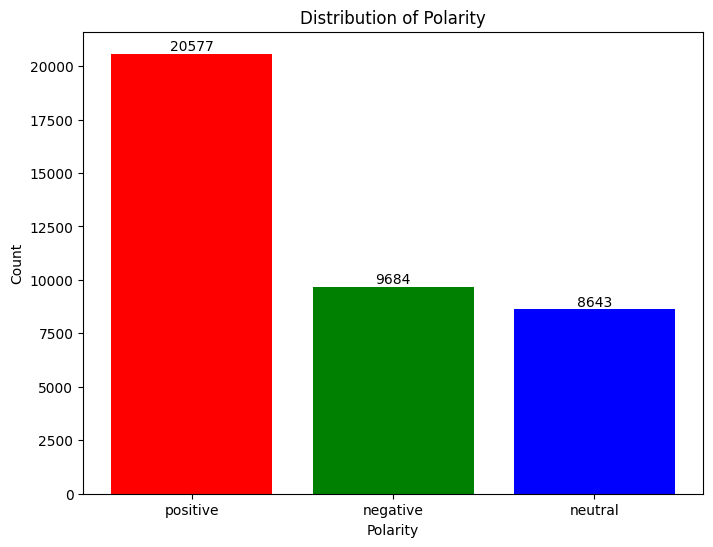

In [18]:
# Visualisasi banyaknya polarity negatif, positif, dan netral

polarity_counts = clean_df['polarity'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(polarity_counts.index, polarity_counts.values, color=['red', 'green', 'blue'])
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of Polarity')

for i, j in enumerate(polarity_counts.values):
    plt.text(i, j, str(j), ha='center', va='bottom')
plt.show()

### Undersample

In [19]:
def undersample_data(df, target_column='polarity'):
    # Menghitung jumlah data untuk setiap kelas
    class_counts = df[target_column].value_counts()

    # Menentukan kelas minoritas
    minority_class = class_counts.idxmin()
    minority_count = class_counts.min()

    # Membuat DataFrame baru untuk menyimpan data yang telah di-undersample
    undersampled_df = pd.DataFrame(columns=df.columns)

    # Mengambil semua data dari kelas minoritas
    undersampled_df = pd.concat([undersampled_df, df[df[target_column] == minority_class]])

    # Mengambil sejumlah data dari kelas mayoritas yang sama dengan jumlah data kelas minoritas
    for class_label in class_counts.index:
      if class_label != minority_class:
        class_data = df[df[target_column] == class_label]
        undersampled_df = pd.concat([undersampled_df, class_data.head(minority_count)])

    return undersampled_df

clean_df = undersample_data(clean_df)
print(clean_df['polarity'].value_counts())

polarity
neutral     8643
positive    8643
negative    8643
Name: count, dtype: int64


<ipython-input-19-5f96a7764a57>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  undersampled_df = pd.concat([undersampled_df, df[df[target_column] == minority_class]])


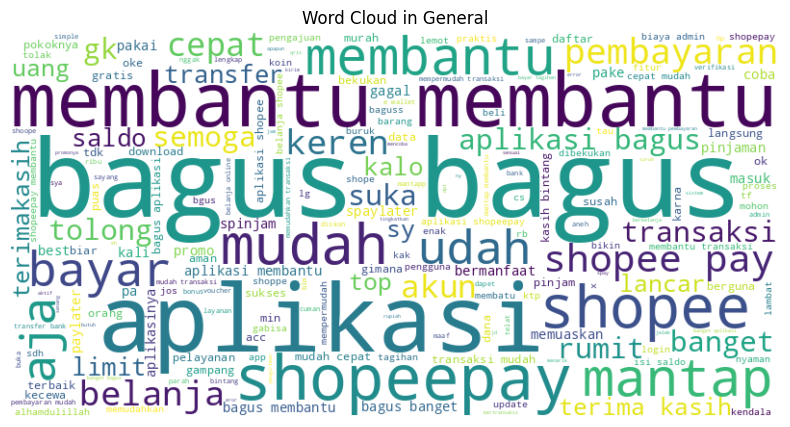

In [20]:
# Membuat visualisasi kata dengan word cloud
word_cloude = WordCloud(width=800, height=400, background_color='white').generate(' '.join(clean_df['text_akhir']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloude, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud in General')
plt.show()

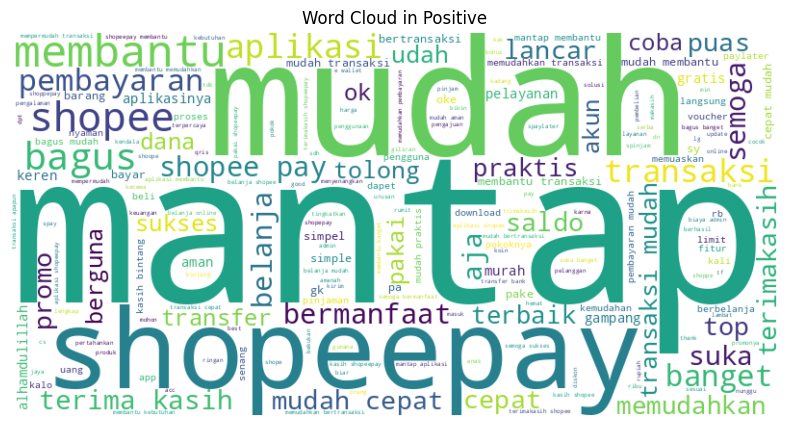

In [21]:
# Membuat visualisasi kata positif dengan word cloud
word_cloude_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(clean_df[clean_df['polarity'] == 'positive']['text_akhir']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloude_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud in Positive')
plt.show()

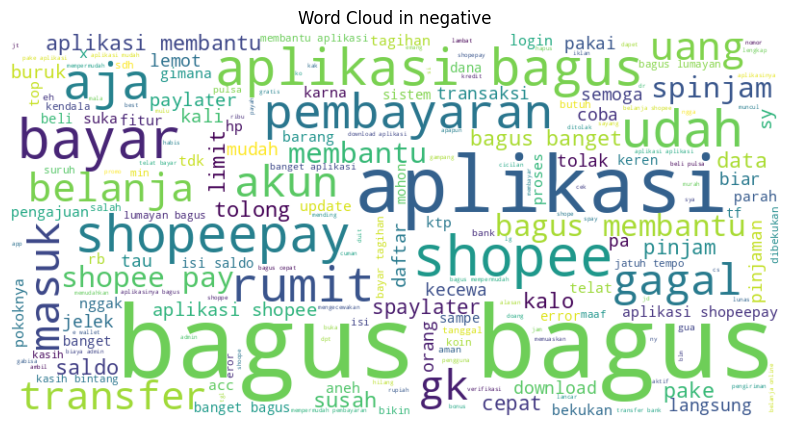

In [22]:
# Membuat visualisasi kata negatif dengan word cloud
word_cloude_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(clean_df[clean_df['polarity'] == 'negative']['text_akhir']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloude_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud in negative')
plt.show()

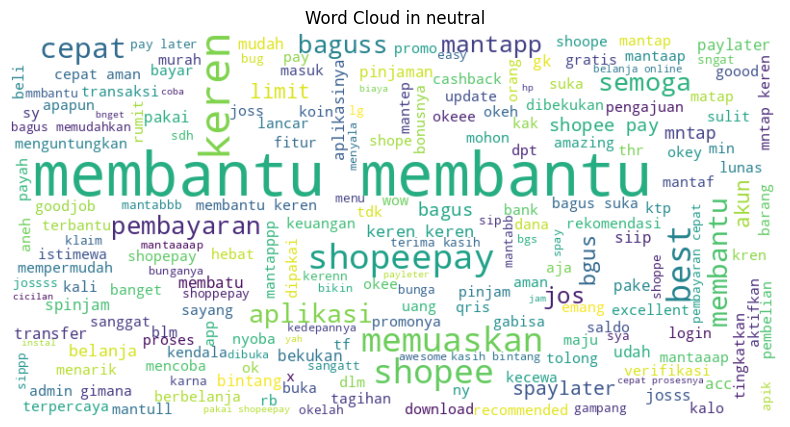

In [23]:
# Membuat visualisasi kata netral dengan word cloud
word_cloude_neutral = WordCloud(width=800, height=400, background_color='white').generate(' '.join(clean_df[clean_df['polarity'] == 'neutral']['text_akhir']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloude_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud in neutral')
plt.show()

# **Modeling**


## **Skema 1** | TF-IDF, 70/30, Random-Forest

### Feature Extraction | TF-IDF

In [24]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

# Bagi data menjadi data latih dan data uji
X_train_TfId, X_test_TfId, y_train_TfId, y_test_TfId = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

### Training | Random-Forest

### Feature Extraction TF-IDF

In [25]:

random_forest = RandomForestClassifier()

random_forest.fit(X_train_TfId.toarray(), y_train_TfId)

y_pred_train_rf = random_forest.predict(X_train_TfId.toarray())
y_pred_test_rf = random_forest.predict(X_test_TfId.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train_TfId)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test_TfId)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.954931129476584
Random Forest - accuracy_test: 0.8737626944337319


## **Skema 2** | TF-IDF, 80/20, DecisionTreeClasifier

### Feature Extraction | TF-IDF

In [26]:

X = clean_df['text_akhir']
y = clean_df['polarity']

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

features_df

X_train_TfId, X_test_TfId, y_train_TfId, y_test_TfId = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Training | DecisionTreeClasifier

In [27]:

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train_TfId.toarray(), y_train_TfId)

y_pred_train_dt = decision_tree.predict(X_train_TfId.toarray())
y_pred_test_dt = decision_tree.predict(X_test_TfId.toarray())

accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train_TfId)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test_TfId)

print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.954779925758087
Decision Tree - accuracy_test: 0.8501735441573467


## **Skema 3** | TF-IDF, 75/25, Deep Learning

### Feature Extraction | TF-IDF, 75/25

In [28]:
# 1. Pisahkan data menjadi fitur dan label
X = clean_df['text_akhir']
y = clean_df['polarity']

# 2. TF-IDF

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# 3. Encode label

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# 4. Split data
X_train_TfId, X_test_TfId, y_train_TfId, y_test_TfId = train_test_split(X_tfidf, y_categorical, test_size=0.25, random_state=42)

### Training | Deep Learning

In [29]:
# Define the model
model = Sequential([
  Dense(128, activation='relu', input_shape=(X_train_TfId.shape[1],)),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_TfId.toarray(), y_train_TfId, epochs=50, batch_size=32, validation_split=0.25)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_TfId.toarray(), y_test_TfId)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6213 - loss: 0.8288 - val_accuracy: 0.8803 - val_loss: 0.3706
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8787 - loss: 0.4000 - val_accuracy: 0.8836 - val_loss: 0.3595
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8913 - loss: 0.3774 - val_accuracy: 0.8850 - val_loss: 0.3595
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8987 - loss: 0.3592 - val_accuracy: 0.8871 - val_loss: 0.3655
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.3452 - val_accuracy: 0.8881 - val_loss: 0.3648
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9051 - loss: 0.3278 - val_accuracy: 0.8898 - val_loss: 0.3684
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9116 - loss: 0.3157 - val_accuracy: 0.8893 - val_loss: 0.3730
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9161 - loss: 0.3103 - val_accuracy: 0

# Testing

In [30]:
new_text = ["Shopee pay aplikasi yang mantap"]
X_new_tfidf = tfidf.transform(new_text)
y_pred_new = model.predict(X_new_tfidf.toarray())
y_pred_label = le.inverse_transform(np.argmax(y_pred_new, axis=1))
print(f"{new_text[0]} : {y_pred_label[0]}")
print()

new_text = ["Shopee pay aplikasi yang jelek"]
X_new_tfidf = tfidf.transform(new_text)
y_pred_new = model.predict(X_new_tfidf.toarray())
y_pred_label = le.inverse_transform(np.argmax(y_pred_new, axis=1))
print(f"{new_text[0]} : {y_pred_label[0]}")
print()

new_text = ["Shopeepay"]
X_new_tfidf = tfidf.transform(new_text)
y_pred_new = model.predict(X_new_tfidf.toarray())
y_pred_label = le.inverse_transform(np.argmax(y_pred_new, axis=1))
print(f"{new_text[0]} : {y_pred_label[0]}")
print()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Shopee pay aplikasi yang mantap : negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shopee pay aplikasi yang jelek : negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Shopeepay : neutral



In [31]:
!pip install pipreqs

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks/AnalisisSentimental.ipynb" --scan-notebooks

Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 609, in main
    init(args)
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 599, in init
    generate_requirements_file(path, imports, symbol)
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 209, in generate_requirements_file
    with _open(path, "w") as out_file:
  File "/usr/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 91, in _open
    file = open(filename, mode)
           ^^^^^^^^^^^^^^^^^^^^
NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/AnalisisSentimental.ipynb/requirements.txt'


In [35]:
!pip freeze > requirements.txt